Два блока импорта

In [10]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output

In [11]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
from tensorflow.keras import Sequential
import scipy
from scipy.sparse import csr_matrix

# Задание 1 - регрессия. Предсказание цены биткойна #

### Данные ###

Цена биткойна+сделки за несколько лет. Отсюда нужна только итоговая цена, поскольку будет строиться регрессия по ряду.

In [3]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [4]:
df.dropna(inplace = True)

Предсказываться будет временной ряд, будет использоваться только одна переменная Weighted_Price

In [6]:
df['Weighted_Price']

0              4.390000
478            4.390000
547            4.526411
548            4.580000
1224           4.580000
               ...     
4857372    58692.753339
4857373    58693.226508
4857374    58696.198496
4857375    58761.866202
4857376    58764.349363
Name: Weighted_Price, Length: 3613769, dtype: float64

In [7]:
n_x = 500 # количество иксов
n_y = 20 # количесатво игреков для предсказания

Функция ниже вернет промежутки для обучения X - по 1000 значений, игреки - по 50 значений.

Другими словами, нейронка будет учиться предсказывать 50 следующих значений по 1000 предыдущих.

In [8]:
def return_XY(data, start_idx, final_index, x_interval, y_interval):
    """data - univatiate"""
    data = np.array(data)
    X = []
    Y = []
    for i in range(start_idx, start_idx + final_index, 1):
        X.append(data[i:i + x_interval])
        Y.append(data[i + x_interval:i + x_interval + y_interval])
    return X,Y

In [9]:
X, y = return_XY(df['Weighted_Price'], start_idx = 0, final_index = 100000 , x_interval = n_x, y_interval = n_y)
# выборка из 100000 измерений (в каждом - n_x значений + n_y игреков)

In [10]:
len(X), len(y)

(100000, 100000)

Text(0.5, 1.0, 'time/price')

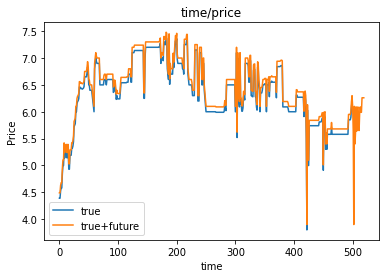

In [11]:
plt.plot(X[0])
plt.plot(np.concatenate([X[0], y[0]])+0.1)
plt.legend(['true','true+future'])
plt.xlabel('time')
plt.ylabel('Price')
plt.title('time/price')

### Простая нейросеть с полносвязными слоями без наворотов (pytorch) ###

In [21]:
torch.cuda.is_available()

True

Нейронку сделал на торче

In [23]:
class Net(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Net, self).__init__()
        # слои
        self.input_d = torch.nn.Linear(n_x, n_hidden_neurons)
        self.lrelu = torch.nn.LeakyReLU()
        self.output_d = torch.nn.Linear(n_hidden_neurons, n_y)
        
    def forward(self, x):
        x = self.input_d(x)
        x = self.lrelu(x)
        x = self.output_d(x)
        return x
my_net = Net(10)

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_net = my_net.to(device) # сетку в видеокарту

In [25]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(my_net.parameters())

In [26]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=5, 
                                                       threshold=0.001, threshold_mode='abs')
# т.е. если loss в течение patience = 5 эпох не будет меняться сильнее, чем 0.001, то lr делится на 2

In [27]:
my_net.train(mode = True) # перевод в режим обучения

Net(
  (input_d): Linear(in_features=500, out_features=10, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (output_d): Linear(in_features=10, out_features=20, bias=True)
)

Функция для обучения. Смешивать данные не стал.

In [28]:
def fit_model(X_train, y_train, X_val = None, y_val = None, epochs = 10, batch_size = 16, verbose = 0):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    if ((X_val != None) and (y_val != None) ):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
    loss_train = []
    loss_val = []
    for _ in zip(tqdm(range(epochs)), range(epochs)):
        for idx in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            X_batch = X_train[idx:idx+batch_size]
            y_batch = y_train[idx:idx+batch_size]
            #print(X_batch.shape, y_batch.shape)
            predictions = my_net.forward(X_batch)
            loss_ = loss(y_batch, predictions)
            loss_.backward()
            optimizer.step()
        
        train_preds = my_net.forward(X_train)
        temp_loss_train = loss(train_preds, y_train)
        loss_train.append( temp_loss_train )
        if ( (X_val != None) and (y_val != None) ):
            val_preds = my_net.forward(X_val)
            loss_val.append(loss(val_preds, y_val))
        
        if (verbose == 1):
            #clear_output()
            print (temp_loss_train)
            
    if (len(loss_val)>0):
        return loss_train, loss_val
    else: 
        return loss_train

In [29]:
# преобразование данных в торчевские тензоры
X_t = torch.FloatTensor(X[:90000])
y_t = torch.FloatTensor(y[:90000])

In [30]:
X_t.shape, y_t.shape

(torch.Size([90000, 500]), torch.Size([90000, 20]))

In [31]:
l_loss = fit_model(X_t, y_t, epochs = 15, batch_size = 64, verbose = 1)

  7%|██▊                                        | 1/15 [00:06<01:24,  6.06s/it]

tensor(99.1037, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█████▋                                     | 2/15 [00:07<00:42,  3.29s/it]

tensor(71.0144, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|████████▌                                  | 3/15 [00:08<00:28,  2.41s/it]

tensor(53.1511, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|███████████▍                               | 4/15 [00:10<00:22,  2.01s/it]

tensor(42.0749, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|██████████████▎                            | 5/15 [00:11<00:17,  1.77s/it]

tensor(37.2721, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|█████████████████▏                         | 6/15 [00:12<00:14,  1.64s/it]

tensor(44.6623, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████████████████████                       | 7/15 [00:14<00:12,  1.57s/it]

tensor(50.9442, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|██████████████████████▉                    | 8/15 [00:15<00:10,  1.50s/it]

tensor(38.8524, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████████████████████████▊                 | 9/15 [00:17<00:08,  1.47s/it]

tensor(30.7281, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|████████████████████████████              | 10/15 [00:18<00:07,  1.46s/it]

tensor(26.5778, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|██████████████████████████████▊           | 11/15 [00:20<00:05,  1.48s/it]

tensor(24.1493, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|█████████████████████████████████▌        | 12/15 [00:21<00:04,  1.47s/it]

tensor(22.0364, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████████████████████████████████▍     | 13/15 [00:22<00:02,  1.47s/it]

tensor(28.9681, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|███████████████████████████████████████▏  | 14/15 [00:24<00:01,  1.44s/it]

tensor(22.1578, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████████████████████████████████████| 15/15 [00:25<00:00,  1.72s/it]

tensor(23.8339, device='cuda:0', grad_fn=<MseLossBackward0>)


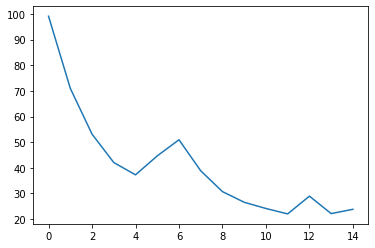

In [32]:
l_loss = [i.cpu().detach().numpy() for i in l_loss]
# лосс в оперативную память для визуализации
plt.plot(l_loss)
plt.xlabel('Эпохи')
plt.ylabel('Потери')

In [34]:
# предсказание на n_y шагов
pr = my_net.forward( torch.FloatTensor(X[-1]).to(device) )

In [35]:
y[-1]

array([117.49028545, 117.5       , 117.4906383 , 117.5       ,
       117.5       , 117.49015102, 117.49017398, 117.53      ,
       117.52152542, 117.52      , 117.5268811 , 117.53328008,
       117.52666667, 117.53966538, 117.54      , 117.53975322,
       117.54      , 117.525     , 117.54      , 117.5319499 ])

Text(0.5, 1.0, 'time/price')

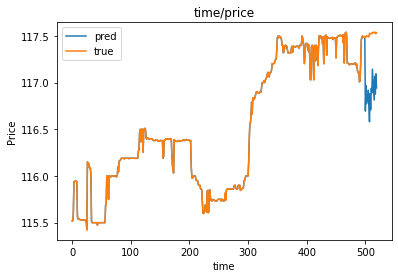

In [37]:
pred = list(X[-1]) + list(pr.cpu().detach().numpy())
true = list(X[-1]) + list(y[-1])
plt.plot(range(len(pred)), pred)
plt.plot(range(len(true)), true)
plt.legend(['pred','true'])
plt.xlabel('time')
plt.ylabel('Price')
plt.title('time/price')

### LSTM (pytorch) ###

Попробовал использовать LSTM-ячейки

In [12]:
n_x = 500
n_y = 70

In [13]:
X, y = return_XY(df['Weighted_Price'], start_idx = 0, final_index = 10000 , x_interval = n_x, y_interval = n_y)

In [14]:
# преобразование данных в торчевские тензоры
X_t = torch.FloatTensor(X[:9000])
y_t = torch.FloatTensor(y[:9000])

In [15]:
class LSTMNet(torch.nn.Module):
    def __init__(self, n_x, n_hidden_neurons):
        super(LSTMNet, self).__init__()
        self.input_d = torch.nn.LSTM(n_x, n_hidden_neurons, batch_first=True)
        self.lrelu = torch.nn.LeakyReLU()
        self.output_d = torch.nn.Linear(n_hidden_neurons, n_y)
        
    def forward(self, x):
        x, _ = self.input_d(x)
        x = self.lrelu(x)
        x = self.output_d(x)
        return x

In [16]:
net2 = LSTMNet(n_x, n_x)
loss = torch.nn.MSELoss()
optimizer_2 = torch.optim.Adam(net2.parameters())
net2.train(mode = True)

LSTMNet(
  (input_d): LSTM(500, 500, batch_first=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (output_d): Linear(in_features=500, out_features=70, bias=True)
)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net2 = net2.to(device) # сетку в видеокарту

In [18]:
# для LSTM нужны свои размерности
#X_tr_reshape = torch.reshape(X_t,   (X_t.shape[0], 1, X_t.shape[1]))
#y_tr_reshape = torch.reshape(y_t,   (y_t.shape[0], 1, y_t.shape[1]))
# можно было так
# X_t.view(1, X_t.shape[0], X_t.shape[1]

X_tr_reshape = X_t.view(X_t.shape[0], 1, X_t.shape[1])
y_tr_reshape = y_t.view(y_t.shape[0], 1, y_t.shape[1])

In [19]:
X_tr_reshape.shape, y_tr_reshape.shape

(torch.Size([9000, 1, 500]), torch.Size([9000, 1, 70]))

Немного более простая функция для обучения

In [20]:
def fit_model_LSTM(X_train, y_train, X_val = None, y_val = None, epochs = 40, batch_size = 64, verbose = 0):
    loss_train = []
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    for _ in zip(tqdm(range(epochs)), range(epochs)):
        for idx in range(0, len(X_train), batch_size):
            optimizer_2.zero_grad()
            X_batch = X_train[idx:idx+batch_size]
            y_batch = y_train[idx:idx+batch_size]
            predictions = net2.forward(X_batch)
            loss_value = loss(y_batch, predictions)
            loss_value.backward()
            optimizer_2.step()
        
        train_preds = net2.forward(X_train)
        temp_loss = loss(train_preds, y_train)
        loss_train.append( temp_loss )
        if (verbose == 1):
            print(temp_loss)
    return loss_train

In [24]:
loss_lstm = fit_model_LSTM(X_tr_reshape, y_tr_reshape, epochs = 5,  batch_size = 64, verbose = 1)

 20%|████████▊                                   | 1/5 [00:00<00:00,  4.01it/s]

tensor(20.3739, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|█████████████████▌                          | 2/5 [00:00<00:00,  4.06it/s]

tensor(20.4190, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████████████████████████▍                 | 3/5 [00:00<00:00,  4.08it/s]

tensor(19.9637, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|███████████████████████████████████▏        | 4/5 [00:00<00:00,  3.99it/s]

tensor(19.6537, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]

tensor(19.4542, device='cuda:0', grad_fn=<MseLossBackward0>)


In [25]:
X_t.shape

torch.Size([9000, 500])

Text(0, 0.5, 'Потери')

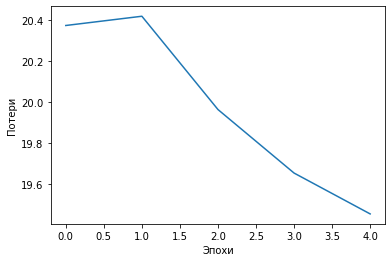

In [27]:
loss_lstm = [i.cpu().detach().numpy() for i in loss_lstm]
plt.plot(loss_lstm)
plt.xlabel('Эпохи')
plt.ylabel('Потери')

In [28]:
torch.FloatTensor(X[-1]).view(1, 1, X[-1].shape[0])

tensor([[[10.0300,  9.4500,  9.4500,  9.4500,  9.4500,  9.4500,  9.4500,
           9.4100,  9.3313,  9.3300,  9.3700,  9.3300,  9.3200,  9.3996,
           9.3200,  9.3700,  9.7900,  9.6300,  9.6200,  9.3500,  9.3300,
           9.3300,  9.3300,  9.3300,  9.3200,  9.4000,  9.4300,  9.4300,
           9.3734,  9.4495,  9.3300,  9.5500,  9.5500,  9.6000,  9.6300,
           9.5900,  9.8000,  9.8000,  9.6900,  9.6900,  9.7900,  9.7900,
           9.7900,  9.7900,  9.9901,  9.5200,  9.3200,  9.3200,  9.3200,
           9.3052,  9.3000,  9.2992,  9.0619,  8.9100,  8.9000,  8.8800,
           8.8800,  8.8500,  8.8300,  8.8112,  8.8100,  8.7994,  8.7822,
           8.7000,  8.6800,  8.6700,  8.6600,  8.6200,  8.6005,  8.6000,
           8.5400,  8.9000,  8.5197,  8.5000,  8.4206,  8.3600,  8.2000,
           8.2000,  8.1000,  8.0100,  8.0000,  8.6000,  8.0300,  8.5900,
           8.0900,  8.5700,  8.1357,  8.0000,  8.5700,  7.8700,  7.8289,
           8.5700,  7.8800,  7.9900,  7.9029,  8.57

In [29]:
pr = net2.forward( torch.FloatTensor(X[-1]).view(1, 1, X[-1].shape[0]).to(device)) 

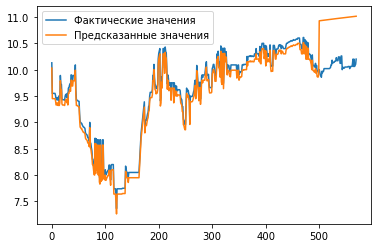

In [44]:
plt.plot(np.concatenate([X[-1], y[-1]])+0.1)
plt.plot((list(X[-1]) + list(pr[0][0].cpu().detach().numpy()))) # больше похоже на белый шум какой-то
plt.legend(['Фактические значения','Предсказанные значения'])

Более-менее предсказывает.

Тут у меня не получилось разобраться с размерностями(

In [157]:
n_x = 500
n_y = 70

In [158]:
X, y = return_XY(df['Weighted_Price'], start_idx = 0, final_index = 10000 , x_interval = n_x, y_interval = n_y)

In [159]:
# преобразование данных в торчевские тензоры
X_t = torch.FloatTensor(X[:90000])
y_t = torch.FloatTensor(y[:90000])

In [160]:
#X_tr_reshape = X_t.view(1, X_t.shape[0], X_t.shape[1])
#y_tr_reshape = y_t.view(1, y_t.shape[0], y_t.shape[1])

In [161]:
X_t.shape, y_t.shape

(torch.Size([10000, 500]), torch.Size([10000, 70]))

In [110]:
#X_tr_reshape.shape, y_tr_reshape.shape

(torch.Size([1, 10000, 500]), torch.Size([1, 10000, 70]))

In [242]:
class Conv_net(torch.nn.Module):
    def __init__(self, n_x, n_hidden_neurons, n_y):
        super(Conv_net, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels = 1, out_channels=n_x, kernel_size=2)
        self.conv2 = torch.nn.Conv1d(in_channels = n_x, out_channels=10, kernel_size=2)
        self.pool = torch.nn.MaxPool1d(kernel_size = 7)
        self.lrelu = torch.nn.LeakyReLU()
        self.output_d = torch.nn.Linear(n_hidden_neurons, n_y)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.lrelu(x)
        x = self.output_d(x)
        return x

In [243]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conv_net = Conv_net(n_x, 70, n_y)
conv_net = conv_net.to(device) # сетку в видеокарту
loss = torch.nn.MSELoss()
optimizer_3 = torch.optim.Adam(conv_net.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, mode='min',
                                                       factor=0.5, patience=5, 
                                                       threshold=0.001, threshold_mode='abs')
# т.е. если loss в течение patience = 5 эпох не будет меняться сильнее, чем 0.001, то lr делится на 2

In [244]:
conv_net.train(mode = True) # перевод в режим обучения

Conv_net(
  (conv1): Conv1d(1, 500, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(500, 10, kernel_size=(2,), stride=(1,))
  (pool): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (output_d): Linear(in_features=70, out_features=70, bias=True)
)

In [245]:
def fit_model(X_train, y_train, X_val = None, y_val = None, epochs = 10, batch_size = 16, verbose = 0):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    if ((X_val != None) and (y_val != None) ):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
    loss_train = []
    loss_val = []
    for _ in zip(tqdm(range(epochs)), range(epochs)):
        for idx in range(0, len(X_train), batch_size):
            optimizer_3.zero_grad()
            
            X_batch = X_train[idx:idx+batch_size]
            y_batch = y_train[idx:idx+batch_size]
            #X_batch = X_batch.reshape(X_batch.shape[0], X_batch.shape[1], 1)
            #y_batch = y_batch.reshape(y_batch.shape[0], y_batch.shape[1], 1)
            print(X_batch.shape)
            
            predictions = conv_net.forward(X_batch)
            loss_ = loss(y_batch, predictions)
            loss_.backward()
            optimizer_3.step()
        
        train_preds = conv_net.forward(X_train)
        temp_loss_train = loss(train_preds, y_train)
        loss_train.append( temp_loss_train )
        if ( (X_val != None) and (y_val != None) ):
            val_preds = conv_net.forward(X_val)
            loss_val.append(loss(val_preds, y_val))
        
        if (verbose == 1):
            #clear_output()
            print (temp_loss_train)
            
    if (len(loss_val)>0):
        return loss_train, loss_val
    else: 
        return loss_train

In [246]:
l_loss = fit_model(X_t, y_t, epochs = 15, batch_size = 16, verbose = 1)

  0%|                                                   | 0/15 [00:00<?, ?it/s]

torch.Size([16, 500])


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [500, 1, 2], but got 2-dimensional input of size [16, 500] instead

# Задание 2 - классификация с картинками #

### Загрузка и работа с данными ###

Данные - датасет с кошками и собаками. Всего 25000 картинок.

Загрузка картинок.

In [3]:
images = []
labels = []
for _, file in zip(tqdm(range(25000)), glob.glob("train//*.jpg")):
    images.append(load_img(file, target_size = (120, 120)))
    labels.append(str(file)[6:9])

100%|███████████████████████████████████| 25000/25000 [02:29<00:00, 166.87it/s]


Перенос в формат массивов.

In [6]:
images_arr = np.array([asarray(pic) for _, pic in zip( tqdm(range(len(images))), images )])

100%|██████████████████████████████████| 25000/25000 [00:12<00:00, 2007.89it/s]


Можно посмотреть несколько штук.

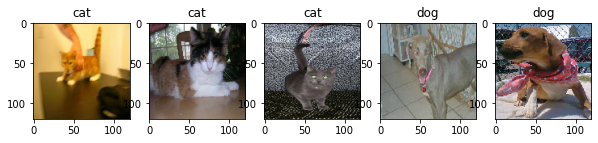

In [4]:
fig, ax = plt.subplots(1,5,figsize = (10,10))
for i, num, img in zip(range(0, 5), range(0, 25000, 5000), images[0:-1:5000]):
    ax[i].imshow(img)
    ax[i].set_title(label = str(labels[num]))

Небольшая работа с данными, чтобы сетка лучше их кушала.

In [13]:
ohe = OneHotEncoder()
y_binary = ohe.fit_transform(np.array(labels).reshape(-1,1))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images_arr, y_binary, shuffle = True, train_size=0.7)

In [15]:
y_train = csr_matrix(y_train).toarray()

In [16]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [17]:
X_train = X_train / 255
X_test = X_test / 255

In [18]:
X_train.shape, y_train.shape

((17500, 120, 120, 3), (17500, 2))

### Нейросети на керасе (для разнообразия) ###

#### Простая через Sequential ####

In [19]:
block = Sequential()
block.add(keras.Input(shape=(120,120,3)))
block.add(keras.layers.Conv2D(filters = 3, strides = 1, kernel_size = (3,3), input_shape=(120,120,3)))
block.add(keras.layers.Conv2D(filters = 5, strides = 1, kernel_size = (3,3)))
block.add(keras.layers.Conv2D(filters = 2, strides = 1, kernel_size = (2,2)))
block.add(keras.layers.MaxPool2D(pool_size=(5, 5)))
#block.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
block.add(keras.layers.BatchNormalization()) # благодаря ей уже на первой эпохе train acc>0.6
block.add(keras.layers.Flatten())
block.add(keras.layers.Dense(20))
block.add(keras.layers.LeakyReLU())
block.add(keras.layers.Dense(128))
block.add(keras.layers.LeakyReLU())
block.add(keras.layers.Dense(64))
block.add(keras.layers.LeakyReLU())
block.add(keras.layers.Dense(2, activation = 'sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
block.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 3)       84        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 5)       140       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 115, 115, 2)       42        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 2)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 2)         8         
_________________________________________________________________
flatten (Flatten)            (None, 1058)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                2

In [21]:
block.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
X_train[0].shape, y_train[0].shape, 

((120, 120, 3), (2,))

In [24]:
history = block.fit(X_train[:1000], y_train[:1000], epochs = 3, batch_size = 128, verbose = 1, validation_split = 0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/3
900/900 [==============================] - 25s 28ms/sample - loss: 0.6651 - acc: 0.5983 - val_loss: 0.6420 - val_acc: 0.6450
Epoch 2/3
900/900 [==============================] - 25s 28ms/sample - loss: 0.6141 - acc: 0.6389 - val_loss: 0.6384 - val_acc: 0.6800
Epoch 3/3
900/900 [==============================] - 26s 29ms/sample - loss: 0.5977 - acc: 0.6706 - val_loss: 0.6539 - val_acc: 0.6750


In [29]:
history.history

{'loss': [0.6650583145353529, 0.6141382582982381, 0.597673991786109],
 'acc': [0.59833336, 0.6388889, 0.67055553],
 'val_loss': [0.6420180797576904, 0.6383607983589172, 0.6538652777671814],
 'val_acc': [0.645, 0.68, 0.675]}

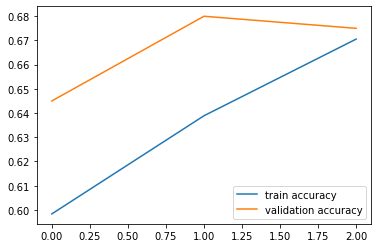

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train accuracy','validation accuracy'])
# переобучение после 1-вой эпохи

#### Прямым проходом вручную ####

In [31]:
def My_net(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(filters = 48, strides = 1, kernel_size = (2,2), input_shape=input_shape)(inputs)
    x = keras.layers.Conv2D(filters = 64, strides = 1, kernel_size = (2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters = 32, strides = 2, kernel_size = (2,2))(x)
    x = keras.layers.MaxPool2D(pool_size=(3, 3))(x)
    
    x = keras.layers.Conv2D(filters = 20, strides = 1, kernel_size = (2,2))(x)
    #x = keras.layers.Conv2D(filters = 6, strides = 1, kernel_size = (2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Conv2D(filters = 1, strides = 2, kernel_size = (2,2))(x)
    #x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    x = keras.layers.Dense(20)(x)
    x = keras.layers.LeakyReLU()(x)
    #x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(50)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dense(10)(x)
    outputs = keras.layers.Dense(2, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

In [34]:
model = My_net((120, 120, 3))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 119, 119, 48)      624       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 118, 118, 64)      12352     
_________________________________________________________________
batch_normalization_3 (Batch (None, 118, 118, 64)      256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 59, 59, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 20)        2580

In [35]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [37]:
history = model.fit(X_train[:1000], y_train[:1000], epochs = 5, batch_size = 128, verbose = 1, validation_split = 0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 171s 190ms/sample - loss: 0.6857 - acc: 0.6222 - val_loss: 0.6670 - val_acc: 0.5900
Epoch 2/5
900/900 [==============================] - 169s 187ms/sample - loss: 0.5877 - acc: 0.6811 - val_loss: 0.6605 - val_acc: 0.6200
Epoch 3/5
900/900 [==============================] - 165s 184ms/sample - loss: 0.5374 - acc: 0.7244 - val_loss: 0.6755 - val_acc: 0.6000
Epoch 4/5
900/900 [==============================] - 165s 183ms/sample - loss: 0.4539 - acc: 0.7878 - val_loss: 0.6601 - val_acc: 0.5900
Epoch 5/5
900/900 [==============================] - 169s 188ms/sample - loss: 0.4080 - acc: 0.8089 - val_loss: 0.6975 - val_acc: 0.5900


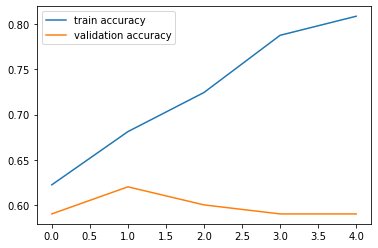

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train accuracy','validation accuracy'])
# переобучение после 1-вой эпохи, также, как и в прошлый раз

In [347]:
class CatNet(torch.nn.Module):
    def __init__(self):
        super(CatNet, self).__init__()
        
        # enc
        #self.conv0 = torch.nn.Conv2d(in_channels = 3, out_channels = 6, stride = 1, kernel_size = (2,2), )
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 6, stride = 1, kernel_size = (5,5))
        self.conv2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16, stride = 1, kernel_size = (5,5))
        #self.pool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride = 2)
        self.flat = torch.nn.Flatten()
        
        # classifier
        self.d1 = torch.nn.Linear(in_features = 200704, out_features = 16)
        self.act = torch.nn.LeakyReLU()
        self.d2 = torch.nn.Linear(in_features = 16, out_features = 10)
        self.d3 = torch.nn.Linear(in_features = 10, out_features = 2)
        
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.pool(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.d1(x)
        x = self.act(x)
        x = self.d2(x)
        x = self.act(x)
        x = self.d3(x)
        return x

In [348]:
my_net = CatNet()

In [349]:
#list(my_net.parameters())

In [350]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_net.parameters())

In [351]:
my_net.train(mode = True) # перевод в режим обучения

CatNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (d1): Linear(in_features=200704, out_features=16, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (d2): Linear(in_features=16, out_features=10, bias=True)
  (d3): Linear(in_features=10, out_features=2, bias=True)
)

Функция для обучения. Смешивать данные не стал.

In [357]:
def fit_model(X_train, y_train, X_val = None, y_val = None, epochs = 10, batch_size = 16, verbose = 0):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    if ((X_val != None) and (y_val != None) ):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
    loss_train = []
    loss_val = []
    for _ in zip(tqdm(range(epochs)), range(epochs)):
        for idx in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            X_batch = X_train[idx:idx+batch_size]
            y_batch = y_train[idx:idx+batch_size]
            #print(X_batch.shape, y_batch.shape)
            predictions = my_net.forward(X_batch)
            loss_ = loss(y_batch, predictions)
            loss_.backward()
            optimizer.step()
        
        train_preds = my_net.forward(X_train)
        temp_loss_train = loss(train_preds, y_train)
        loss_train.append( temp_loss_train )
        if ( (X_val != None) and (y_val != None) ):
            val_preds = my_net.forward(X_val)
            loss_val.append(loss(val_preds, y_val))
        
        if (verbose == 1):
            #clear_output()
            print (temp_loss_train)
            
    if (len(loss_val)>0):
        return loss_train, loss_val
    else: 
        return loss_train

In [358]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)

In [359]:
X_train.shape, y_train.shape

(torch.Size([17500, 120, 120, 3]), torch.Size([17500, 2]))

In [360]:
X_train_t = X_train.reshape(X_train.shape[0], 3, X_train.shape[1], X_train.shape[2])
# shape = (3, 120, 120)

In [361]:
acc_tr, acc_val = fit_model(X_train_t[:500], y_train[:500], X_val = X_train_t[500:550], y_val = y_train[500:550], verbose = 1)

  0%|                                                   | 0/10 [00:01<?, ?it/s]


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 215296000 bytes.

In [362]:
plt.plot(acc_tr)
plt.plot(acc_val)
plt.legend(['train','val'])

NameError: name 'acc_tr' is not defined